# Pipeline et modèle

In [341]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures,RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, cross_validate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import pickle

In [342]:
df = pd.read_csv("../data/AmesHousing.csv")
df["Neighborhood"]=df["Neighborhood"].astype(str)
ngbd=list(df.Neighborhood.value_counts()[df.Neighborhood.value_counts()>15

].index)
df=df.loc[df['Neighborhood'].isin(ngbd)]

Il ne faut selectionner que 10 features, on supprime Neighborhood qui est trop complexe à traiter, ainsi que bsmt Qual et garage Finish qui sont trop proches d'autres variables

In [343]:
numeric_features = ["Year Built", "Total Bsmt SF", "Bedroom AbvGr", "Gr Liv Area", "Garage Area", "Overall Qual", "Full Bath"]
ordinal_features = [ "Exter Qual",  "Kitchen Qual"]
cat_feature = ["Neighborhood"]
all_col = numeric_features.copy()
all_col.extend(ordinal_features)
all_col.extend(cat_feature)

X = df[all_col]
y = df[["SalePrice"]]

X["Total Bsmt SF"].fillna(1052, inplace=True)
X["Garage Area"].fillna(472, inplace=True)

/tmp/ipykernel_13733/1629926845.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Total Bsmt SF"].fillna(1052, inplace=True)
/tmp/ipykernel_13733/1629926845.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Garage Area"].fillna(472, inplace=True)


In [344]:
X.columns = ['Year_Built', 'Total_Bsmt_SF', "Bedroom AbvGr", 'Gr_Liv_Area','Garage_Area', 'Overall_Qual', 'Full_Bath', 'Exter_Qual',
       'Kitchen_Qual', 'Neighborhood']

In [345]:

X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True ,test_size=0.2,random_state=42,)

In [346]:
numeric_transformer = MinMaxScaler()

exter_cat = [ 'Po', 'Fa','TA', 'Gd','Ex']
kitchen_cat = [ 'Po', 'Fa','TA', 'Gd',"Ex"]

ordinal_transformer = OrdinalEncoder(categories=[exter_cat, kitchen_cat])

categorical_transformer = OneHotEncoder()

In [347]:
numeric_features = ["Year_Built", "Total_Bsmt_SF", "Bedroom AbvGr", "Gr_Liv_Area", "Garage_Area", "Overall_Qual", "Full_Bath"]
ordinal_features = [ "Exter_Qual",  "Kitchen_Qual"]
cat_feature = ["Neighborhood"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, cat_feature)
    ]
)

In [348]:
reg = LinearRegression()

In [349]:
pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('reg', reg)
])

pipe.fit(X_train, y_train) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Year_Built',
                                                   'Total_Bsmt_SF',
                                                   'Bedroom AbvGr',
                                                   'Gr_Liv_Area', 'Garage_Area',
                                                   'Overall_Qual',
                                                   'Full_Bath']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['Exter_Qual',
                                                   'Kitchen_Qual']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Neighborhood'])])),
                ('reg', LinearRegression())])

In [350]:
pipe.score(X_test,y_test)



0.8409460943500303

In [351]:
predict_train  = pipe.predict(X_train)
predict_test  = pipe.predict(X_test)

# Root Mean Squared Error on train and test date
print('MAE on train data: ', mean_absolute_error(y_train, predict_train))
print('MAE on test data: ',  mean_absolute_error(y_test, predict_test))

MAE on train data:  20670.691892377607
MAE on test data:  20496.036129693977


In [352]:
filename = '../real_estate_app/main_app/static/models/finalized_model.pkl'
pickle.dump(pipe, open(filename, 'wb'))

In [353]:
dico = {'Year_Built': 2000, 'Total_Bsmt_SF': 1, '1st_Flr_SF': 1, 'Gr_Liv_Area': 1, 'Garage_Area': 1, 'Overall_Qual': 1, 'Full_Bath': 1, 'Exter_Qual': 'Po', 'Kitchen_Qual': 'Po', 'Neighborhood': 'Gilbert'}

In [354]:
help(pipe.predict)

Help on method predict in module sklearn.pipeline:

predict(X, **predict_params) method of sklearn.pipeline.Pipeline instance
    Transform the data, and apply `predict` with the final estimator.
    
    Call `transform` of each transformer in the pipeline. The transformed
    data are finally passed to the final estimator that calls `predict`
    method. Only valid if the final estimator implements `predict`.
    
    Parameters
    ----------
    X : iterable
        Data to predict on. Must fulfill input requirements of first step
        of the pipeline.
    
    **predict_params : dict of string -> object
        Parameters to the ``predict`` called at the end of all
        transformations in the pipeline. Note that while this may be
        used to return uncertainties from some models with return_std
        or return_cov, uncertainties that are generated by the
        transformations in the pipeline are not propagated to the
        final estimator.
    
        .. versionad

# Création d'un nouveau modèle 

In [355]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),["Neighborhood"]),
    (RobustScaler(),["Year_Built", "Total_Bsmt_SF", "Bedroom AbvGr", "Gr_Liv_Area", "Garage_Area", "Overall_Qual", "Full_Bath"]),
    ( OrdinalEncoder(categories=[exter_cat, kitchen_cat]),[ "Exter_Qual",  "Kitchen_Qual"])
    
    )

In [356]:
model = make_pipeline(transformer,PolynomialFeatures(),ElasticNet(random_state=42 ))
model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Neighborhood']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['Year_Built',
                                                   'Total_Bsmt_SF',
                                                   'Bedroom AbvGr',
                                                   'Gr_Liv_Area', 'Garage_Area',
                                                   'Overall_Qual',
                                                   'Full_Bath']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['Exter_Qual',
                                                   'Kitchen_Qual'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('elasticnet', ElasticNet(random_state=42))])

In [357]:
model.score(X_test,y_test)

0.8666384626509919

In [358]:
param_search = {'elasticnet__alpha':np.linspace(0,500,1000),'elasticnet__l1_ratio':[1],'polynomialfeatures__degree':[1,2]}
random_search = RandomizedSearchCV(model, param_distributions=param_search, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+10, tolerance: 1.215e+09
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e+10, tolerance: 1.224e+09
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

{'polynomialfeatures__degree': 2, 'elasticnet__l1_ratio': 1, 'elasticnet__alpha': 27.52752752752753}


/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e+10, tolerance: 1.508e+09
  model = cd_fast.enet_coordinate_descent(


In [359]:
params = {'elasticnet__alpha':np.linspace(random_search.best_params_['elasticnet__alpha']-2,random_search.best_params_['elasticnet__alpha']+2,100)}
grid=GridSearchCV(random_search.best_estimator_, param_grid=params, scoring='neg_mean_absolute_error',n_jobs=-1, cv=5)
grid.fit(X_train, y_train)

/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.495e+09, tolerance: 1.177e+09
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.601e+09, tolerance: 1.224e+09
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Neighborhood']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['Year_Built',
                                                                          'Total_Bsmt_SF',
                                                                          'Bedroom '
                                                                          'AbvGr',
                                                                          'Gr_Liv_Area',
                                                                          'Garage_Area',
                                                                          'Overall_Qual',
                                                                          'Full_Bath']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=...
       28.35581036, 28.3962144 , 28.43661844, 28.47702248, 28.51742652,
       28.55783056, 28.5982346 , 28.63863864, 28.67904268, 28.71944672,
       28.75985076, 28.8002548 , 28.84065884, 28.88106288, 28.92146692,
       28.96187096, 29.002275  , 29.04267904, 29.08308308, 29.12348712,
       29.16389116, 29.2042952 , 29.24469924, 29.28510329, 29.32550733,
       29.36591137, 29.40631541, 29.44671945, 29.48712349, 29.52752753])},
             scoring='neg_mean_absolute_error')

In [360]:
grid.best_params_


{'elasticnet__alpha': 29.52752752752753}

In [361]:
best_model= grid.best_estimator_

In [362]:
grid.best_score_

-17433.266376446638

In [363]:
best_model.score(X_test,y_test)

0.8908837555401027

/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+10, tolerance: 1.508e+09
  model = cd_fast.enet_coordinate_descent(


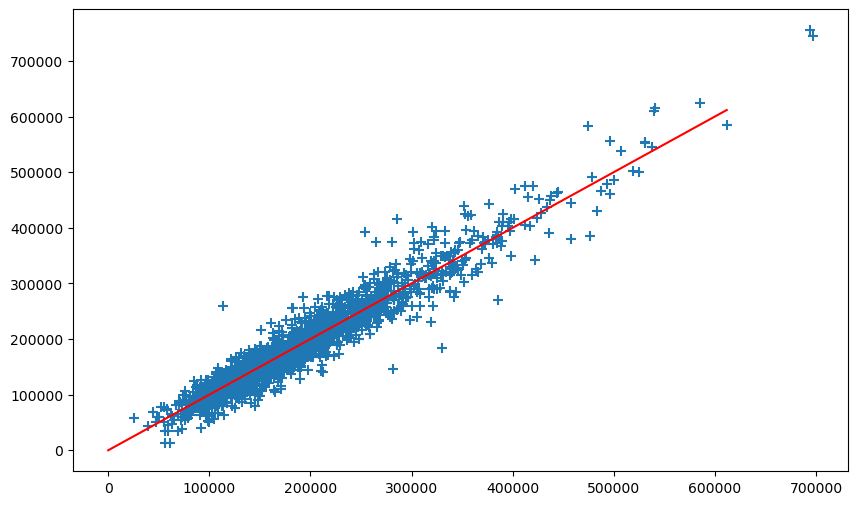

In [364]:
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_train)
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()


In [365]:
y_pred_test = best_model.predict(X_test)

In [366]:
print('MAE on train data: ', mean_absolute_error(y_train,y_pred))
print('MAE on test data: ', mean_absolute_error(y_test,y_pred_test))


MAE on train data:  15754.833836601225
MAE on test data:  16831.07185779158


In [367]:
coef=best_model[-1].coef_
coef_df= pd.DataFrame(coef, columns=['coef'] ,index=best_model[:-1].get_feature_names_out())
coef_df=coef_df[coef_df['coef'] != 0]
coef_df['features']=coef_df.index
coef_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

,coef,features
0,98984.331796,onehotencoder__Neighborhood_NoRidge robustscal...
1,38000.033409,onehotencoder__Neighborhood_NridgHt robustscal...
2,36404.251609,onehotencoder__Neighborhood_StoneBr robustscal...
3,31494.230955,robustscaler__Year_Built
4,30968.680818,robustscaler__Gr_Liv_Area
...,...,...
152,-11845.312987,onehotencoder__Neighborhood_NoRidge robustscal...
153,-12507.775894,onehotencoder__Neighborhood_Sawyer robustscale...
154,-13098.063324,onehotencoder__Neighborhood_NridgHt robustscal...
155,-17086.759142,onehotencoder__Neighborhood_NridgHt ordinalenc...


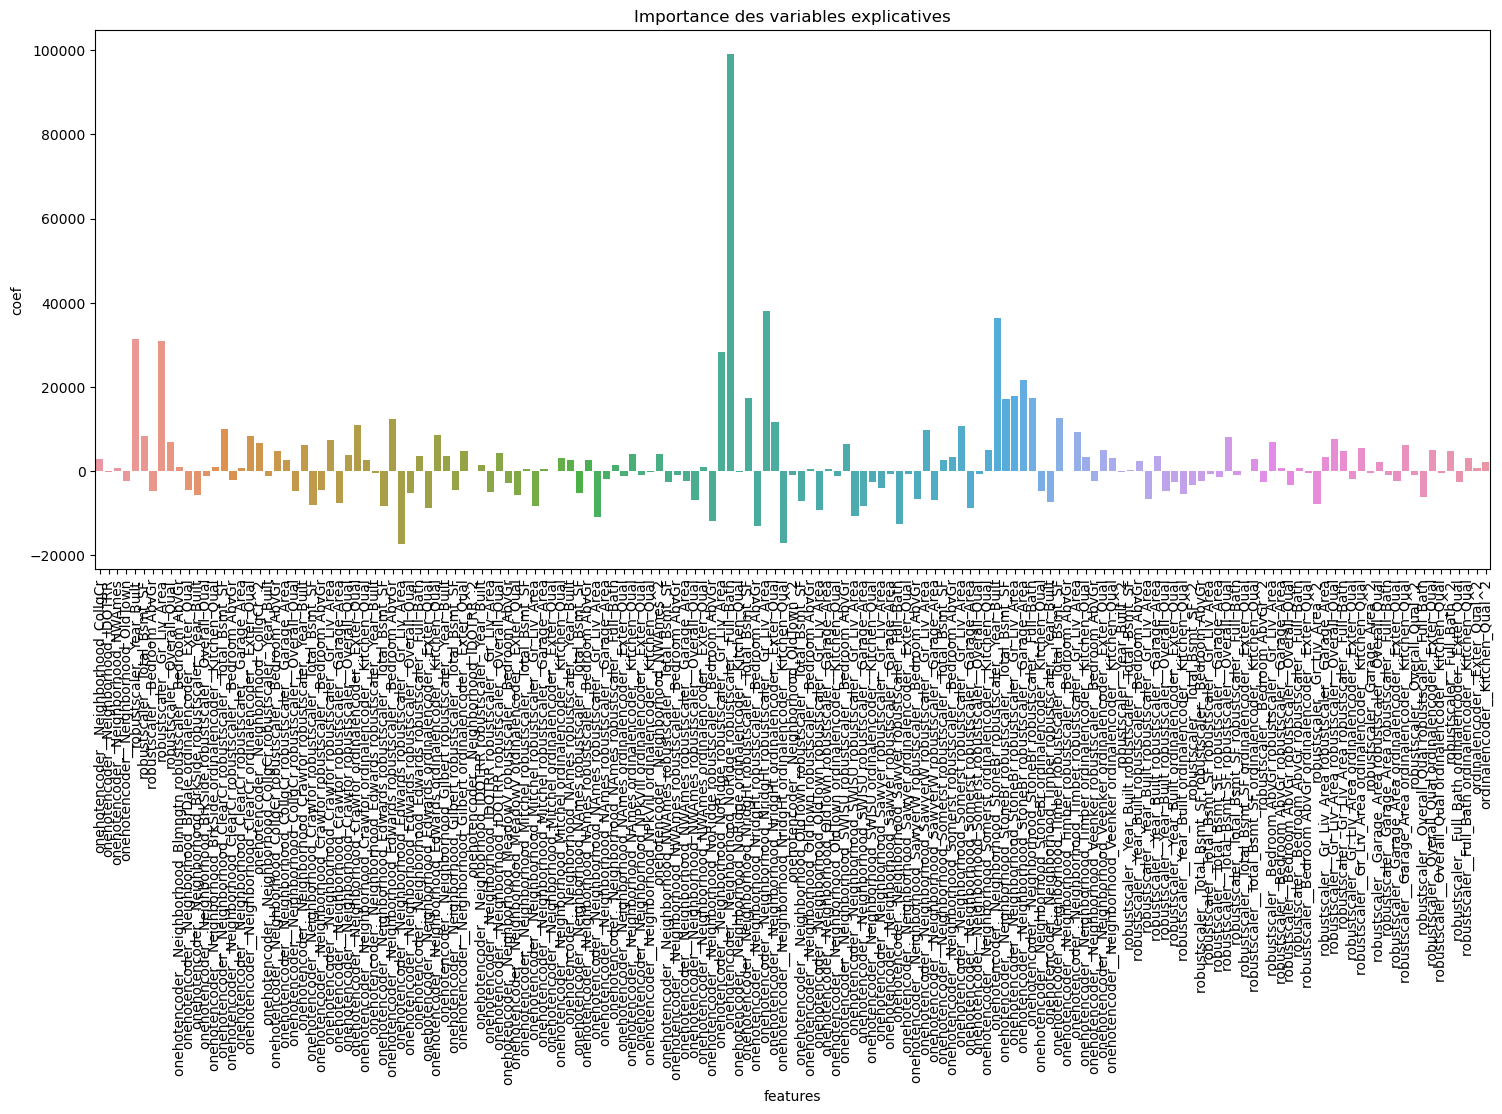

In [368]:
plt.figure(figsize=[18,7])
sns.barplot(data=coef_df,x='features',y='coef')
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()